In [53]:
import torch
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [55]:
with open("C:/Users/User/Documents/Machine Learning/social listening project/tf_idf.csv", encoding="utf-8") as f:
    # đọc file vector, đưa về dạng array[float]
    reader = csv.reader(f)
    data_list = [row for row in reader]
    data_list = np.asarray(data_list[0:5500],dtype=np.float64)
    data_list = np.concatenate((np.ones((data_list.shape[0],1)), data_list), axis = 1)

In [56]:
with open("C:/Users/User/Documents/Machine Learning/social listening project/Data dùng được.csv", encoding="utf-8") as f:
    reader = csv.reader(f)
    label_list = [row for row in reader]
    label_list = label_list[0:5500]
    # 0 = Ukraina and 1 = Nga
    for i in range(0,len(label_list)):
        if label_list[i][1]=="U":
            label_list[i]=0
        else: 
            label_list[i]=1 

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data_list, label_list, train_size=5000/5500,test_size=500/5500, random_state=0)
X_train = torch.tensor(X_train,dtype=torch.float64)
X_test = torch.tensor(X_test,dtype=torch.float64)
y_train = torch.tensor(y_train,dtype=torch.float64)
y_test = torch.tensor(y_test,dtype=torch.float64)

In [58]:
def sigmoid(s):
    return (1/(1 + 1e-6 + torch.exp(-s)))

In [59]:
def loss_function(w,X_train,y_train):
    z = sigmoid(torch.matmul(w,X_train.T))
    loss = torch.sum(-(y_train*torch.log(z)+(1-y_train)*torch.log(1-z)))
    return loss

In [60]:
def make_tensor(mini_batch,batch_size):
    X_list, y_list = mini_batch
    X_mini = X_list[0].reshape(1,-1)
    y_mini = y_list[0].reshape(1)
    for i in range(1,batch_size):
        X_mini = torch.cat((X_mini,X_list[i].reshape(1,-1)),0)
        y_mini = torch.cat((y_mini,y_list[i].reshape(1)),0)
    return X_mini, y_mini

In [61]:
def create_mini_batches(X_train, y_train, batch_size, N):
    mini_batches = []
    # xáo thứ tự training set
    mix_id = torch.randperm(N)
    n_minibatches = N // batch_size
    i = 0
    # lấy các mini_batchs chẵn
    for i in range(n_minibatches + 1):
        mini_batch = mix_id[i * batch_size:(i + 1)*batch_size]
        X_mini = [X_train[j] for j in mini_batch]
        y_mini = [y_train[j] for j in mini_batch]
        mini_batches.append((X_mini, y_mini))
    # lấy một mini_batch gồm các data còn lại
    if N % batch_size != 0:
        mini_batch = mix_id[i * batch_size + 1:]
        X_mini = [X_train[j] for j in mini_batch]
        y_mini = [y_train[j] for j in mini_batch]
        mini_batches.append((X_mini, y_mini))
    mini_batches.pop()
    return mini_batches

In [89]:

def logistic_sigmoid_regression(X_train, y_train, w_init, eta, batch_size, tol = 1e-4, max_count = 50000):
    w = [w_init]    # vector trọng số
    #it = 0
    N = X_train.shape[0]  # số data
    count = 0   # đến số vong lặp
    check_w_after = 100  # check lại w sau mỗi 20 lần lặp
    loss_list = [0]
    count_list = []
    num_batch = N//batch_size
    if num_batch*batch_size<N:
        num_batch+=1
    while count<max_count:
        mini_batches = create_mini_batches(X_train, y_train, batch_size, N)
        for i in range(num_batch):
            X_mini, y_mini = make_tensor(mini_batches[i],batch_size)
            z_mini = sigmoid(torch.matmul(w[-1],X_mini.T))
            w_new = w[-1] + eta*torch.matmul((y_mini - z_mini),X_mini)
            count += 1
              
            if count%check_w_after == 0:   
                print(count,loss_list[-1])  
                loss_list.append(loss_function(w_new,X_train,y_train))  
                count_list.append(count)
                if abs(loss_list[-1]-loss_list[-2])<tol:
                    return w[-1],loss_list,count_list
            w.append(w_new)
    return w[-1],loss_list,count_list

In [91]:
eta = .005  # learning rate = 0.002
d = X_train.shape[1]
batch_size = 20
w_init = torch.randn(d,dtype=torch.float64)  # lấy random một vector w
w, loss_list, count_list = logistic_sigmoid_regression(X_train, y_train, w_init, eta, batch_size)
w = w.reshape((1,-1))

In [92]:
loss = []
for i in range(1,len(loss_list)):
    loss.append(loss_list[i].item())

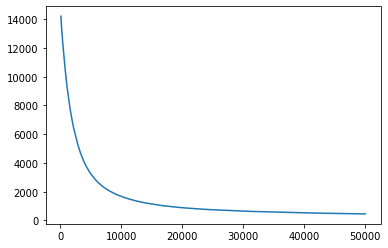

In [93]:
plt.plot(count_list,loss)

In [86]:
predict = sigmoid(torch.matmul(w,torch.transpose(X_test,0,1)))
count = 0
for i in range(0,len(predict[0])):
    x = predict[0][i]
    y = y_test[i]
    s = x + y
    if (x + y >=1.5) or (x + y <0.5):
        count+=1
    #print("%.4f" %predict[0][i],y_test[i])
print(count)
print(len(y_test))
print(count/len(y_test))

315
500
0.63
